In [1]:
## Bring in needed mods
import pandas as pd, numpy as np

## Load in matplot lib
from matplotlib import pyplot as plt

## Set random seed
np.random.seed(711)

In [2]:
## Load in sims
import mystatslib as sims

## Load in mod
import epigenomevisulization as epv

In [3]:
## Set path to cell line information
cellinfo = pd.read_csv('../DATA/H3K4me3_Cellline_info.csv')

## Print the head to screen
cellinfo.head()

,Cellline,Replicate1,Replicate2
0,HAP-1,ENCFF941CSK,ENCFF683RST
1,MG63,ENCFF778ZUK,ENCFF289JFI
2,RWPE2,ENCFF639EED,ENCFF696EBU
3,SJCRH30,ENCFF409CAG,ENCFF249YKT
4,SJSA1,ENCFF942YVE,ENCFF759EUU


In [4]:
## Make a dictonary of replicates
rep1 = cellinfo.Replicate1.tolist()
rep2 = cellinfo.Replicate2.tolist()

## Append the replicates pair wise 
repa = rep1 + rep2
repz = rep2 + rep1

## Make a dictionary of replicates
repdict = dict(zip(repa,repz))

In [5]:
## Set a list of autosomes and sex chromosomes we are interested in
chrlist = ['chr%s'%(int(i+1)) for i in range(22)] + ['chrX','chrY']

## Check that we have twenty-four
assert len(chrlist) == 24, "We are missing chromosomes!"

In [6]:
## Set path to input H3K4me3 data
H3K4me3_path = '../DATA/BEDS/H3K4me3.ceil.counts.genomic.10000.counts.bed.gz'

## Load in the dataframe 
H3K4me3 = epv.loaddf(H3K4me3_path)

## Parse only the chroms of interest
H3K4me3 = H3K4me3[(H3K4me3.Chrom.isin(chrlist))]

## Iterate thru the list of samples, starting from 4th column over 
for c in H3K4me3.columns[3:].tolist():
    
    ## Gather a new name 
    bamname = c.split('.bam')[0]
    
    ## Rename
    H3K4me3[bamname] = H3K4me3[c]
    
    ## Drop old
    H3K4me3.drop(c,axis=1,inplace=True)
    
## View the head
H3K4me3.head()

,Chrom,Left,Right,ENCFF683RST,ENCFF941CSK,ENCFF289JFI,ENCFF778ZUK,ENCFF639EED,ENCFF696EBU,ENCFF249YKT,ENCFF409CAG,ENCFF759EUU,ENCFF942YVE
0,chr1,1,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr1,10001,20000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,chr1,20001,30000,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
3,chr1,30001,40000,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
4,chr1,40001,50000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [7]:
## Gather the smaples 
samples = epv.getsamples(H3K4me3)

## Print the first 5 names and the number of samples
samples[:5], len(samples)

(['ENCFF683RST', 'ENCFF941CSK', 'ENCFF289JFI', 'ENCFF778ZUK', 'ENCFF639EED'],
 10)

In [8]:
## Show the change in norm. mutual. info.
x,y = H3K4me3[samples[0]].values,H3K4me3[samples[1]].values

## Print the values 
sims.conmi(x,y,cozero=False), sims.conmi(x,y,cozero=True)

(0.8524899798035324, 0.7167429562567805)

In [9]:
## Show the change in R2
sims.copearson(x,y,cozero=False)**2, sims.copearson(x,y,cozero=True)**2

(0.9172017888533542, 0.8618668493168606)

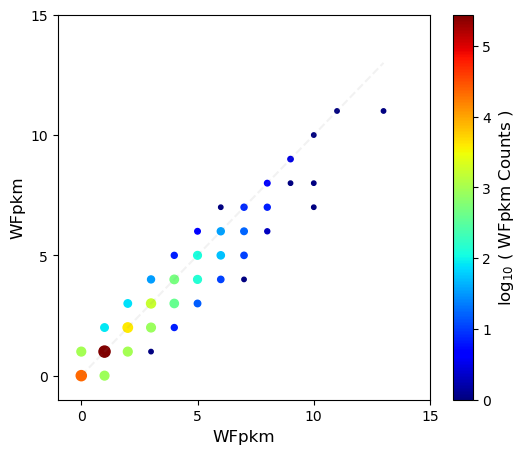

In [10]:
## Plot a commet plot 
epv.cometplot(x,y);

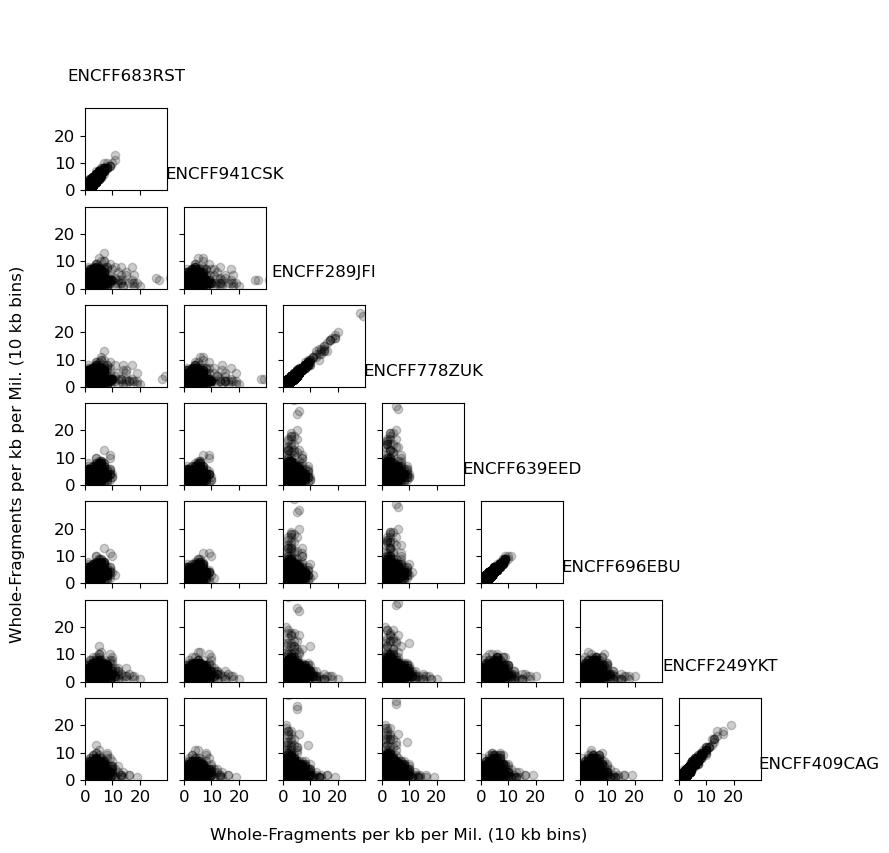

In [11]:
## Plot a corr grid of the bi-variate scatter plots 
f,a = epv.corrgrid(H3K4me3,samples[:8])

In [12]:
## Initilize result
results = []

## Iterate thru the samples 
for i,si in enumerate(samples):
    for j,sj in enumerate(samples):
        
        ## If the row is larger than column 
        if i > j:
            ## Switch between true and false in co-zero removal 
            for cz in (True,False):
                ## Gather the x and y 
                x,y = H3K4me3[si].values,H3K4me3[sj].values
                
                ## Calculate pearson's R, R2, nmi, and spearman
                pr = sims.copearson(x,y,cozero=cz)
                r2 = pr**2
                mi = sims.conmi(x,y,cozero=cz)
                sp = sims.cospearman(x,y,cozero=cz)
                
                ## Calc a boolean to see if this comparison is a replicate
                isrep = (sj == repdict[si])
                
                ## Append the results
                results.append((si,sj,cz,isrep,pr,r2,mi,sp))

## Make results into a dataframe
results = pd.DataFrame(results,columns=['Sample1','Sample2','Cozero','Isrep','PearsonR','Rsquared','NMI','Spearman'])
            
## Show head
results.head()

,Sample1,Sample2,Cozero,Isrep,PearsonR,Rsquared,NMI,Spearman
0,ENCFF941CSK,ENCFF683RST,True,True,0.928368,0.861867,0.716743,0.849001
1,ENCFF941CSK,ENCFF683RST,False,True,0.957707,0.917202,0.852490,0.953600
2,ENCFF289JFI,ENCFF683RST,True,False,0.638485,0.407663,0.378206,0.591166
3,ENCFF289JFI,ENCFF683RST,False,False,0.771673,0.595480,0.645816,0.855036
4,ENCFF289JFI,ENCFF941CSK,True,False,0.625692,0.391490,0.379742,0.585880


In [13]:
## Set the order of the statistics to plot 
stats = ['Spearman','PearsonR','Rsquared','NMI']

## Set the stat lables, make sure the match above 
stat_labels = ['Spearman '+ '\u03C1', 'Pearson $R$', '$R^2$','Normalized Mutual Information']

## Form into a dictionary
stat_label_dict = dict(zip(stats,stat_labels))

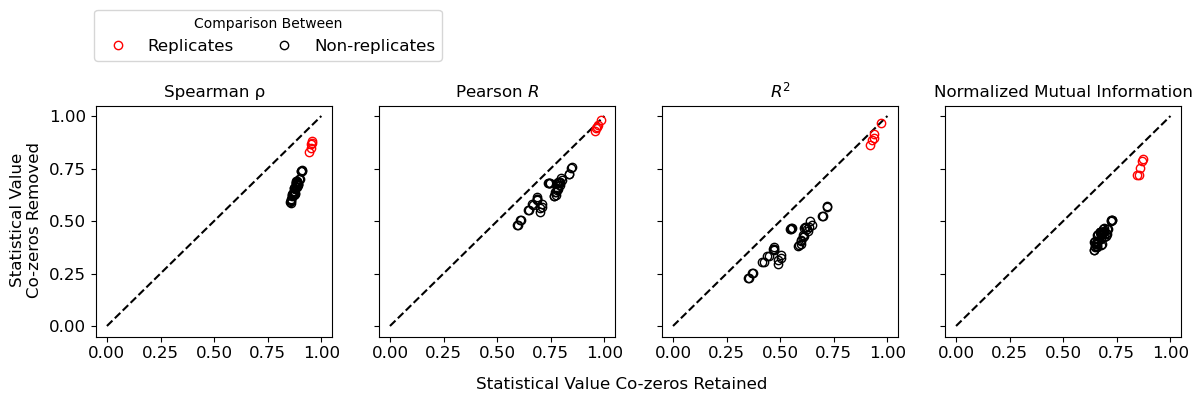

In [14]:
## Set the subplots, equal axis, with white background
fig,ax = plt.subplots(1,4,figsize=(14,3),sharex=True,sharey=True)
fig.set_facecolor('w')

for i,s in enumerate(stats):
    ## Set the axis 
    plt.sca(ax[i])
    
    ## Set the title
    plt.title(stat_label_dict[s],fontsize=12)
    
    ## Plot a one to one line
    plt.plot([0,1],[0,1],'k--')
    
    for b in (True,False):
        ## Gather the x and y 
        x = results[(results.Cozero==False) & (results.Isrep==b)][s].values
        y = results[(results.Cozero==True)  & (results.Isrep==b)][s].values
    
        ## Plot the results 
        plt.plot(x,y,'o',fillstyle='none',color='r' if b else 'k')
    
    ## Reset the x and y ticks
    plt.xticks(np.arange(0,1.25,0.25),fontsize=12)
    plt.yticks(np.arange(0,1.25,0.25),fontsize=12)
    
## SEt first axis 
plt.sca(ax[0])

## Add mock poitns for making a legend 
plt.plot(0.25,0.75,'o',fillstyle='none',color='r',label='Replicates')
plt.plot(0.25,0.75,'o',fillstyle='none',color='k',label='Non-replicates')

## Color over the points 
plt.plot(0.25,0.75,'o',color='w',ms=10)

## Call legend
plt.legend(bbox_to_anchor=(1.5,1.45),fontsize=12,title='Comparison Between',ncol=2)
    
## Annotate the x and y axis 
fig.text(x=0.075,y=0.5,s='Statistical Value\nCo-zeros Removed',fontsize=12,rotation=90,va='center',ha='center');
fig.text(x=0.5,y=-0.05,s='Statistical Value Co-zeros Retained',fontsize=12,rotation=0,va='center',ha='center');

In [15]:
## Save out the data
results.to_csv('../DATA/H3K4me3_stats.csv',index=False)

In [16]:
## Read in the file 
with open('../DATA/H3K4me3.counts.txt','r') as infile:
    fragcounts = infile.readlines()
    infile.close()

## Write ftn to get bam name
def getbam(a):
    return a.split('/')[-1].split('.bam')[0]

## make into a tmp dataframe by zipping 
tmp = pd.DataFrame(list(zip([getbam(a) for a in fragcounts[::2]],[int(a) for a in fragcounts[1::2]])))
tmp.columns = ['Bam','Count']

## Add a filtereed boolean 
tmp['Filtered'] = [False if (i%2==0) else True for i in range(tmp.shape[0])]

## Take the unfilt counts 
pref = tmp[~(tmp.Filtered)].copy()
pref['Total Fragments'] = pref.Count

## Take the filte coutns 
filt = tmp[(tmp.Filtered)].copy()
filt['Filtered Fragments'] = filt.Count

## Calculate the max fpkms
maxes = H3K4me3[H3K4me3.columns[3:]].max()

## Format the max  df 
maxdf = pd.DataFrame(maxes).reset_index()
maxdf.columns = ['Bam','Max WFpkm (10 kb bins)']

## Gather the cell info for replicates 1 and 2
rep1in = cellinfo[['Cellline','Replicate1']]
rep2in = cellinfo[['Cellline','Replicate2']]

## Format into df
repin = pd.DataFrame(rep1in.values.tolist() + rep2in.values.tolist(),columns=['Cell Line','Bam'])

## merge results 
tmp = pref[['Bam','Total Fragments']].merge(filt[['Bam','Filtered Fragments']]).merge(maxdf).merge(repin)

## Set the assay type 
tmp['Assay'] = 'H3K4me3'

## Saveout the csv 
tmp.to_csv('../DATA/H3K4me3.formated.counts.csv',index=False)

## Print to screen
tmp

,Bam,Total Fragments,Filtered Fragments,Max WFpkm (10 kb bins),Cell Line,Assay
0,ENCFF683RST,86716019,78112300,13.0,HAP-1,H3K4me3
1,ENCFF941CSK,100953140,90845864,11.0,HAP-1,H3K4me3
2,ENCFF289JFI,70898108,64534217,31.0,MG63,H3K4me3
3,ENCFF778ZUK,84905617,77422930,32.0,MG63,H3K4me3
4,ENCFF639EED,79648038,69807038,10.0,RWPE2,H3K4me3
5,ENCFF696EBU,75286399,65118423,11.0,RWPE2,H3K4me3
6,ENCFF249YKT,83941981,77134376,55.0,SJCRH30,H3K4me3
7,ENCFF409CAG,86985228,79654231,51.0,SJCRH30,H3K4me3
8,ENCFF759EUU,74121515,66510060,85.0,SJSA1,H3K4me3
9,ENCFF942YVE,76886308,68668188,82.0,SJSA1,H3K4me3
